In [141]:
# Put all library imports in this block!
import pandas as pd
!pip install numdifftools
import numdifftools as nd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math
from scipy.optimize import minimize
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from sklearn.metrics import r2_score

In [142]:
# Data prep
data_vintage = pd.read_csv('2025-08-MD.csv')
data_vintage = data_vintage[['sasdate', 'UNRATE', 'INDPRO']]
data_vintage = data_vintage.iloc[1:].copy()

df_log_diff = pd.DataFrame()
df_log_diff['DATE'] = pd.to_datetime(data_vintage['sasdate'])
df_log_diff['UNRATE'] = np.log(data_vintage['UNRATE']).diff()
df_log_diff['INDPRO'] = np.log(data_vintage['INDPRO']).diff()
df_log_diff = df_log_diff.iloc[1:].copy()

display(df_log_diff.head())

,DATE,UNRATE,INDPRO
2,1959-02-01,-0.016807,0.019395
3,1959-03-01,-0.052186,0.014300
4,1959-04-01,-0.074108,0.021080
5,1959-05-01,-0.019418,0.014954
6,1959-06-01,-0.019803,0.001137


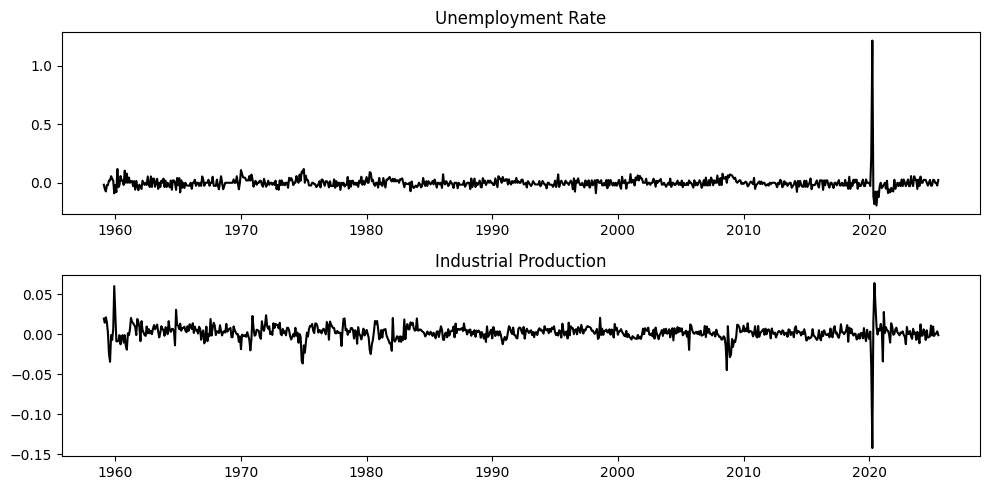

In [143]:
# Plotting log differences
plt.figure(figsize=(10,5))

## Unemployment rate
plt.subplot(2,1,1)
plt.plot(df_log_diff['DATE'], df_log_diff['UNRATE'], color='black')
plt.title('Unemployment Rate')

## Industrial production
plt.subplot(2,1,2)
plt.plot(df_log_diff['DATE'], df_log_diff['INDPRO'], color='black')
plt.title('Industrial Production')

plt.tight_layout()
plt.show()

# Question 2

In [ ]:
model_names = ('AR(1)', 'SESTAR', 'STAR')

def get_total_loss(theta, model_name, x, y = None):

  if model_name == 'AR(1)':
    mu, delta = theta[:2]
  else:
    mu, delta, gamma, alpha, beta = theta

  x = np.asarray(x)
  y = np.asarray(y)

  div = 0

  if model_name == 'SESTAR':
    div = gamma / (1 + np.exp(alpha + beta * x[:-1]))
  elif model_name == 'STAR':
    div = gamma / (1 + np.exp(alpha + beta * y[:-1]))

  resid = x[1:] - mu - (delta + div) * x[:-1]

  return np.sum(resid**2)

In [ ]:
# Test point for total loss (OK)
theta_star = (0, 0.3, 1, 0, 2)

for model in model_names:
  total_loss = get_total_loss(theta_star, model, df_log_diff['UNRATE'], df_log_diff['INDPRO'])
  print(f'Total Loss for {model}: {total_loss:.6f}')

Total Loss for AR(1): 2.420311
Total Loss for SESTAR: 2.687785
Total Loss for STAR: 3.652962


In [ ]:
# Results for Q2

theta_tilde = (0, 0.1, 2, 0, 3)
results_Q2 = {}

for model in model_names:
  total_loss = get_total_loss(theta_tilde, model, df_log_diff['UNRATE'], df_log_diff['INDPRO'])
  print(f'Total Loss for {model}: {total_loss:.6f}')

  results_Q2[model] = {
      'total_loss': total_loss
  }

Total Loss for AR(1): 2.329560
Total Loss for SESTAR: 2.847958
Total Loss for STAR: 5.435420


# Question 3

In [162]:
def estimate_model(theta_init, model_name, x, y=None):

  if model_name not in model_names:
    raise ValueError('Invalid model name specified.')

  if model_name == 'AR(1)':
    theta_init = theta_init[:2]

  result = minimize(get_total_loss,
                    x0=theta_init,
                    args=(model_name, x, y),
                    method='L-BFGS-B')

  if not result.success:
    print(f'\nWarning: Optimization failed for {model_name}.')
    print(f'Message: {result.message}\n')
  else:
    print(f'\nOptimization successful for {model_name}. Total Loss: {result.fun:.6f}\n')

  if model_name == 'AR(1)':
    return np.append(result.x, [0, 0, 0]), result.fun
  else:
    return result.x, result.fun

def fit_values(theta, model_name, x, y=None):

  if model_name == 'AR(1)':
    mu, delta = theta[:2]
  else:
    mu, delta, gamma, alpha, beta = theta

  x = np.asarray(x)
  if y is not None: y = np.asarray(y)

  div = np.zeros_like(x)
  if model_name == 'SESTAR':
    div[1:] = gamma / (1 + np.exp(alpha + beta * x[:-1]))
  elif model_name == 'STAR':
    div[1:] = gamma / (1 + np.exp(alpha + beta * y[:-1]))

  x_fit = mu + (delta + div[1:]) * x[:-1]
  x_fit = np.insert(x_fit, 0, mu / (1 - delta)) # Add 1st observation as unconditional mean

  return x_fit


In [163]:
# Results for Q3

theta_init = (0, 0.3, 0, 0, 6)
date = df_log_diff['DATE']
x = df_log_diff['UNRATE']
y = df_log_diff['INDPRO']

recessions_periods = [
    ('1973-11-01', '1975-03-31'),
    ('1980-01-01', '1980-07-31'),
    ('2007-12-01', '2009-06-30'),
    ('2020-01-01', '2022-05-31')
]

results_Q3 = {}

for model in model_names:

  loss_init = get_total_loss(theta_init, model, x, y)
  print(f'Initial loss: {loss_init:.6f}')

  theta_optim, loss_optim = estimate_model(theta_init, model, x, y)

  if model == 'AR(1)':
        mu, delta = theta_optim[:2]
        theta_optim = np.array([mu, delta, 0, 0, 0])  # to clean up the init values

  results_Q3[model] = {
      'theta': theta_optim,
      'total_loss': loss_optim
  }

  x_fitted = fit_values(theta_optim, model, x, y)

  # Plotting actual vs fitted values
  plt.figure(figsize=(15, 5))
  plt.plot(date, x, label='Observed', color='black')
  plt.plot(date, x_fitted, label=f'Fitted {model}', color='skyblue')

  for start, end in recessions_periods:
    plt.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='red', alpha=0.3)

  plt.title(model, fontsize=13, weight='bold')
  plt.xlabel('Date')
  plt.ylabel('Log-Diff. of Unemployment Rate')
  plt.ylim(-0.2, 1.25)
  plt.legend()

  # Uncomment to store plot
  # plt.savefig(f'UNRATE_fitted_{model}.png', bbox_inches='tight', dpi=300)
  # plt.show()

  plt.close()

theta_hat_star = np.asarray(results_Q3["STAR"]["theta"])

Initial loss: 0.003037

Optimization successful for AR(1). Total Loss: 0.002923

Initial loss: 0.003037

Optimization successful for SESTAR. Total Loss: 0.002738

Initial loss: 0.003037

Optimization successful for STAR. Total Loss: 0.002730



In [150]:
print("θ̂_SESTAR =", results_Q3["SESTAR"]["theta"])

θ̂_SESTAR = [ 6.08186605e-04 -1.45192218e+00  1.89017531e+00 -5.14945062e+00
  3.46190366e+00]


# Question 4

In [151]:
assert "STAR" in results_Q3
print("θ̂_STAR =", results_Q3["STAR"]["theta"])

θ̂_STAR = [ 5.87940640e-04  4.34129511e-01 -1.36557105e+03  1.74396292e+01
  6.74428808e+01]


In [152]:
assert len(theta_hat_star) == 5
date = pd.to_datetime(df_log_diff["DATE"])

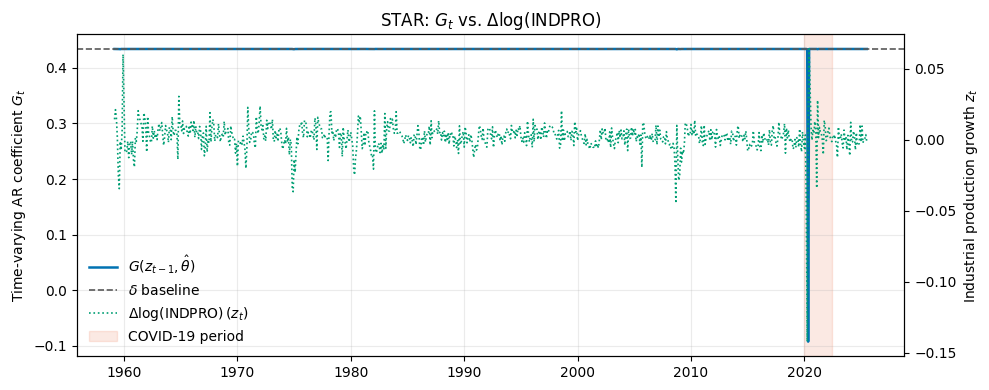

In [153]:
# Results for Q4 (plot G_t and z_t with current θ̂_STAR)

# 1) Parameters and series
mu, delta, gamma, alpha, beta = np.asarray(results_Q3["STAR"]["theta"])
date = pd.to_datetime(df_log_diff["DATE"])
z = df_log_diff["INDPRO"].to_numpy()

# 2) Logistic and alignment
def logistic(u):
    """1/(1+exp(u)) with clipping for numerical stability."""
    u = np.clip(u, -30, 30)
    return 1.0 / (1.0 + np.exp(u))

G          = delta + gamma * logistic(alpha + beta * z[:-1])  # length T-1 uses z_{t-1}
z_align    = z[1:]                                            # aligned with G_t
date_align = date[1:]

# 3) Colors (colorblind-safe + warmer orange-red for COVID)
COL_G      = "#0072B2"  # G_t
COL_DELTA  = "#595959"  # δ baseline
COL_Z      = "#009E73"  # z_t
COL_COVID  = "#E64A19"  # COVID period (orange-red)

# 4) Plot
fig, ax1 = plt.subplots(figsize=(10, 4))

(ln1,) = ax1.plot(date_align, G, color=COL_G, lw=1.8,
                  label=r"$G(z_{t-1}, \hat{\theta})$")
ln2 = ax1.axhline(delta, color=COL_DELTA, lw=1.2, ls="--",
                  label=r"$\delta$ baseline")
ax1.set_ylabel(r"Time-varying AR coefficient $G_t$")
ax1.grid(alpha=0.25)

ax2 = ax1.twinx()
(ln3,) = ax2.plot(date_align, z_align, color=COL_Z, lw=1.2, ls=":",
                  label=r"$\Delta\log(\mathrm{INDPRO})\,(z_t)$")
ax2.set_ylabel(r"Industrial production growth $z_t$")

# COVID shading + legend handle
cov_patch = mpatches.Patch(color=COL_COVID, alpha=0.12, label="COVID-19 period")
ax1.axvspan(pd.Timestamp("2020-01-01"), pd.Timestamp("2022-05-31"),
            color=COL_COVID, alpha=0.12, zorder=0)

# Title & legend (bottom-left)
ax1.set_title(r"STAR: $G_t$ vs. $\Delta\log(\mathrm{INDPRO})$")
handles = [ln1, ln2, ln3, cov_patch]
labels  = [h.get_label() for h in handles]
ax1.legend(handles, labels, loc="lower left", frameon=False)

plt.tight_layout()
plt.show()


In [154]:
print("θ̂_STAR =", results_Q3["STAR"]["theta"])
print("Lengths -> G:", len(G), " z_align:", len(z_align), " date_align:", len(date_align))
print("G_t stats -> min:", np.nanmin(G), " max:", np.nanmax(G), " mean:", np.nanmean(G))

# logistic∈(0,1)
lo, hi = (delta + min(0, gamma), delta + max(0, gamma))
print("Theoretical range approx:", (lo, hi))

# sign(dG/dz) = sign(-γβ)
print("sign(dG/dz) =", np.sign(-gamma * beta))


θ̂_STAR = [ 5.87940640e-04  4.34129511e-01 -1.36557105e+03  1.74396292e+01
  6.74428808e+01]
Lengths -> G: 797  z_align: 797  date_align: 797
G_t stats -> min: -0.09277307973000593  max: 0.43412901736559856  mean: 0.4334298242418699
Theoretical range approx: (np.float64(-1365.136921072758), np.float64(0.4341295111200456))
sign(dG/dz) = 1.0


# Question 5

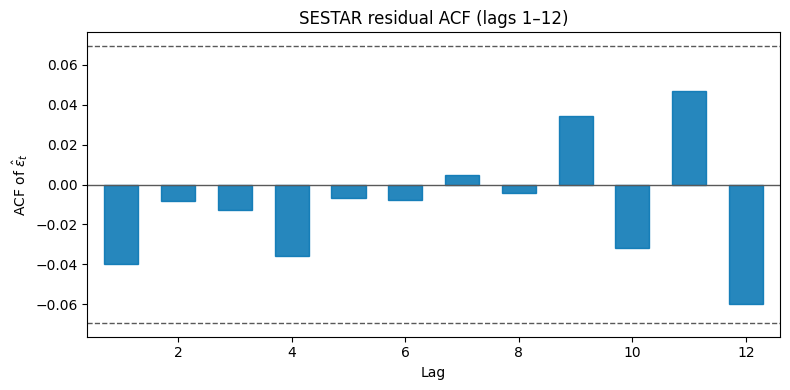

     lb_stat  lb_pvalue
12  9.057318   0.698027

Residual ACF (lags 1..12):
lag  1: -0.040
lag  2: -0.008
lag  3: -0.013
lag  4: -0.036
lag  5: -0.007
lag  6: -0.008
lag  7: +0.005
lag  8: -0.004
lag  9: +0.035
lag 10: -0.032
lag 11: +0.047
lag 12: -0.060

Approx. 95% reference band: ±0.069  (T=797)


In [155]:
# Results for Q5 (SESTAR residuals, ACF (lags 1–12), and Ljung–Box test)

# 1) Read parameters and series
theta_sestar = np.asarray(results_Q3["SESTAR"]["theta"])
mu, delta, gamma, alpha, beta = theta_sestar
date = pd.to_datetime(df_log_diff["DATE"])
x = df_log_diff["UNRATE"].to_numpy()

# 2) Fitted values and residuals for SESTAR
def logistic(u):
    u = np.clip(u, -30, 30)
    return 1.0 / (1.0 + np.exp(u))

g = gamma * logistic(alpha + beta * x[:-1])
x_hat = mu + (delta + g) * x[:-1]

eps = np.empty_like(x, dtype=float)
eps[:] = np.nan
eps[1:] = x[1:] - x_hat                       # residuals aligned to t>=2

# 3) Sample ACF up to lag 12
eps_valid = eps[1:] - np.nanmean(eps[1:])     # demean, drop first NaN
T = len(eps_valid)

def sample_acf(series, max_lag):
    denom = np.sum(series**2)
    acfs = []
    for h in range(1, max_lag+1):
        num = np.sum(series[h:] * series[:-h])
        acfs.append(num / denom)
    return np.array(acfs)

max_lag = 12
rho = sample_acf(eps_valid, max_lag=max_lag)
ci = 1.96 / np.sqrt(T)  # ~95% reference band for white noise

# 4) Plot ACF bars (single, main figure)
lags = np.arange(1, max_lag+1)
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(lags, rho, width=0.6, color="#0072B2", edgecolor="#0072B2", alpha=0.85)
ax.axhline(0, color="#595959", lw=1)
ax.axhline(+ci, color="#595959", lw=1, ls="--")
ax.axhline(-ci, color="#595959", lw=1, ls="--")
ax.set_xlim(0.4, max_lag + 0.6)
ax.set_xlabel("Lag")
ax.set_ylabel(r"ACF of $\hat{\varepsilon}_t$")
ax.set_title("SESTAR residual ACF (lags 1–12)")
plt.tight_layout()
plt.show()

# 5) Ljung–Box test up to lag 12
if acorr_ljungbox is not None:
    lb = acorr_ljungbox(eps_valid, lags=[12], return_df=True)  # columns: lb_stat, lb_pvalue
    print(lb)
else:
    print("statsmodels not available -> skipped Ljung–Box test.")

# 6) Print ACF values and CI
print("\nResidual ACF (lags 1..12):")
for h, r in zip(lags, rho):
    print(f"lag {h:2d}: {r:+.3f}")
print(f"\nApprox. 95% reference band: ±{ci:.3f}  (T={T})")

plt.show()


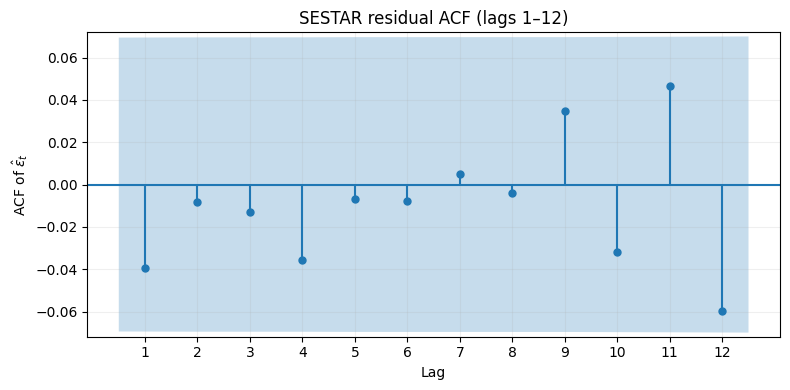

Residual ACF values (lags 1–12):
lag  1: -0.0397
lag  2: -0.0084
lag  3: -0.0129
lag  4: -0.0357
lag  5: -0.0068
lag  6: -0.0079
lag  7: +0.0047
lag  8: -0.0041
lag  9: +0.0346
lag 10: -0.0318
lag 11: +0.0467
lag 12: -0.0599


In [156]:
# different visualisation, which results in the same plot
max_lag = 12
acf_vals = acf(eps_valid, nlags=max_lag, fft=False)[1:]  # drop lag 0
lags = np.arange(1, max_lag + 1)

fig, ax = plt.subplots(figsize=(8, 4))
plot_acf(eps_valid, lags=max_lag, ax=ax, fft=False, zero=False)
ylim = 1.2 * np.nanmax(np.abs(acf_vals))
ax.set_xticks(lags)
ax.set_xticklabels([str(lag) for lag in lags])
ax.set_ylim(-min(1, ylim), min(1, ylim))
ax.set_xlabel("Lag")
ax.set_ylabel(r"ACF of $\hat{\varepsilon}_t$")
ax.set_title("SESTAR residual ACF (lags 1–12)")
ax.grid(alpha=0.2)
plt.tight_layout()
plt.savefig(f'Q5_ACF_SESTAR.png', bbox_inches='tight', dpi=300)
plt.show()


print("Residual ACF values (lags 1–12):")
for h, r in zip(lags, acf_vals):
    print(f"lag {h:2d}: {r:+.4f}")

# Question 6

In [157]:
# Check the data structure from question 3
print(results_Q3)
print(results_Q3.keys())

{'AR(1)': {'theta': array([-0.00037695,  0.10358028,  0.        ,  0.        ,  0.        ]), 'total_loss': np.float64(0.0029227290528539367)}, 'SESTAR': {'theta': array([ 6.08186605e-04, -1.45192218e+00,  1.89017531e+00, -5.14945062e+00,
        3.46190366e+00]), 'total_loss': np.float64(0.002738039046010981)}, 'STAR': {'theta': array([ 5.87940640e-04,  4.34129511e-01, -1.36557105e+03,  1.74396292e+01,
        6.74428808e+01]), 'total_loss': np.float64(0.0027299933836924693)}}
dict_keys(['AR(1)', 'SESTAR', 'STAR'])


In [158]:
# Robust std errors
x = df_log_diff['UNRATE'].to_numpy()
y = df_log_diff['INDPRO'].to_numpy()

# q function for non-linear least squares
def q_t(theta, model, x, y=None):
    mu, delta, gamma, alpha, beta = theta
    fitted = fit_values(theta, model, x, y)
    resid = x[1:] - fitted[1:]
    return resid**2

# Newey–West estimator
def nw(grad, p=12):
    T= grad.shape[0]
    Sigma0 = grad.T @ grad / T #lag 0
    Sigma = Sigma0.copy()
    for j in range(1, p+1):
        coef = 1 - j/(p+1)
        Sigmaj = (grad[j:].T @ grad[:-j]) / T #lag j
        Sigma += coef * (Sigmaj + Sigmaj.T)
    return Sigma

def grad(theta, model, x, y=None):
    q_fun = lambda param: q_t(param, model, x, y)
    return nd.Jacobian(q_fun)(theta)

def hessian_mean(theta, model, x, y=None):
    q_mean = lambda param: q_t(param, model, x, y).mean()
    return nd.Hessian(q_mean)(theta)   # (k × k)

# Results for all the models
robust_se = []

for model in results_Q3.keys():
    theta_hat = results_Q3[model]['theta']
    q = q_t(theta_hat, model, x, y)
    g = grad(theta_hat, model, x, y)
    H = hessian_mean(theta_hat, model, x, y)
    if model == 'AR(1)':
        g = g[:, :2]
        H = H[:2, :2]
    sigular = 1e-8
#     Omega = np.linalg.inv(H + sigular * np.eye(H.shape[0]))
    Omega = np.linalg.inv(H)
    Sigma = nw(g)
    var = Omega @ Sigma @ Omega.T
    se = np.sqrt(np.diag(var))
    robust_se.append((model, theta_hat, se, results_Q3[model]['total_loss']))

print(robust_se)

[('AR(1)', array([-0.00037695,  0.10358028,  0.        ,  0.        ,  0.        ]), array([0.05423912, 1.38127692]), np.float64(0.0029227290528539367)), ('SESTAR', array([ 6.08186605e-04, -1.45192218e+00,  1.89017531e+00, -5.14945062e+00,
        3.46190366e+00]), array([6.20736582e-02, 7.88508461e+00, 1.63921134e+01, 6.72579594e+01,
       6.45969244e+01]), np.float64(0.002738039046010981)), ('STAR', array([ 5.87940640e-04,  4.34129511e-01, -1.36557105e+03,  1.74396292e+01,
        6.74428808e+01]), array([6.28307054e-02, 8.97562851e+00, 1.00096343e+01, 4.34515201e+01,
       4.26024555e+02]), np.float64(0.0027299933836924693))]


In [159]:
# R squared
def r2_stats(model, theta):
    x_fit = fit_values(theta, model, x, y)
    R2 = r2_score(x, x_fit)
    T = len(x)
    k = 2 if model == 'AR(1)' else 5
    R2_adj = 1 - (1 - R2) * (T - 1) / (T - k - 1)
    return R2, R2_adj

In [160]:
# Latex

robust_dict = {m: {"theta": th, "se": se, "loss": loss} for (m, th, se, loss) in robust_se}

def pad_params(model, theta, se):
    if model == 'AR(1)':
        theta = np.array([theta[0], theta[1], np.nan, np.nan, np.nan], dtype=float)
        se    = np.array([se[0],    se[1],    np.nan, np.nan, np.nan], dtype=float)
    return theta, se

def fnum(v, digs=2):
    return "" if v is None or np.isnan(v) else f"{v:.{digs}f}"

def fse(v, digs=2):
    return "" if v is None or np.isnan(v) else f"({v:.{digs}f})"

col_titles   = ['AR', 'SESTAR', 'STAR']
param_labels = [r'$\mu$', r'$\delta$', r'$\gamma$', r'$\alpha$', r'$\beta$']

table_data = {}
for m in results_Q3.keys():
    th, se = robust_dict[m]["theta"], robust_dict[m]["se"]
    th, se = pad_params(m, th, se)
    R2, R2_adj = r2_stats(m, th)
    table_data[m] = {
        "theta": th,
        "se": se,
        "loss": robust_dict[m]["loss"],
        "R2": R2,
        "R2_adj": R2_adj
    }


lines = []
lines.append(r"\begin{table}[htbp]")
lines.append(r"\centering")
lines.append(r"\caption{Estimated parameters with the robust standard errors}")
lines.append(r"\begin{tabular}{lccc}")
lines.append(r"\toprule")
lines.append(r" & " + " & ".join(col_titles) + r" \\")
lines.append(r"\midrule")

for j, lab in enumerate(param_labels):
    est_row = [lab]
    se_row  = [""]
    for m in results_Q3.keys():
        est_row.append(fnum(table_data[m]["theta"][j], 2))
        se_row.append(fse(table_data[m]["se"][j], 2))
    lines.append(" & ".join(est_row) + r" \\")
    lines.append(" & ".join(se_row)  + r" \\")

lines.append(r"\addlinespace")
stat_labels = [r"\emph{Loss}", r"$R^2$", r"$R^2_{\text{adj}}$"]
for stat in stat_labels:
    row = [stat]
    for m in results_Q3.keys():
        if stat == r"\emph{Loss}":
            row.append(fnum(table_data[m]["loss"], 2))
        elif stat == r"$R^2$":
            row.append(fnum(table_data[m]["R2"], 2))
        else:
            row.append(fnum(table_data[m]["R2_adj"], 2))
    lines.append(" & ".join(row) + r" \\")
lines.append(r"\bottomrule")
lines.append(r"\end{tabular}")
lines.append(r"\end{table}")

tex_str = "\n".join(lines)
print(tex_str)

with open("table1.tex", "w", encoding="utf-8") as f:
    f.write(tex_str)

\begin{table}[htbp]
\centering
\caption{Estimated parameters with the robust standard errors}
\begin{tabular}{lccc}
\toprule
 & AR & SESTAR & STAR \\
\midrule
$\mu$ & -0.00 & 0.00 & 0.00 \\
 & (0.05) & (0.06) & (0.06) \\
$\delta$ & 0.10 & -1.45 & 0.43 \\
 & (1.38) & (7.89) & (8.98) \\
$\gamma$ &  & 1.89 & -1365.57 \\
 &  & (16.39) & (10.01) \\
$\alpha$ &  & -5.15 & 17.44 \\
 &  & (67.26) & (43.45) \\
$\beta$ &  & 3.46 & 67.44 \\
 &  & (64.60) & (426.02) \\
\addlinespace
\emph{Loss} & 0.00 & 0.00 & 0.00 \\
$R^2$ & 0.01 & 0.07 & 0.08 \\
$R^2_{\text{adj}}$ & 0.01 & 0.07 & 0.07 \\
\bottomrule
\end{tabular}
\end{table}


# Question 7


In [161]:
GAMMA_IDX = 2  # (mu, delta, gamma, alpha, beta)

def two_sided_p_from_t(t):
    # Normal approx p-value using erf
    return 2.0 * (1.0 - 0.5 * (1.0 + math.erf(abs(t) / math.sqrt(2.0))))

rows = []
for model in ["SESTAR", "STAR"]:
    theta = table_data[model]["theta"]
    sevec = table_data[model]["se"]
    g_est = float(theta[GAMMA_IDX])
    g_se  = float(sevec[GAMMA_IDX])
    tval  = g_est / g_se
    pval  = two_sided_p_from_t(tval)
    rows.append({
        "Model": model,
        "Parameter": "gamma",
        "Estimate": g_est,
        "SE (robust)": g_se,
        "t-stat": tval,
        "p-value": pval
    })

Q7_wald = pd.DataFrame(rows)


print("Q7 — Wald test (two-sided) for non-linear time-dependence (γ = 0)\n")
print(f"{'Model':<8} {'Param':<6} {'Est':>12} {'SE':>12} {'t':>10} {'p':>10}")
for _, r in Q7_wald.iterrows():
    est = fnum(r['Estimate'], 2)
    se  = fse(r['SE (robust)'], 2)
    t   = fnum(r['t-stat'], 3)
    p   = "<1e-16" if (isinstance(r['p-value'], float) and r['p-value'] < 1e-16) else f"{r['p-value']:.3g}"
    print(f"{r['Model']:<8} {r['Parameter']:<6} {est:>12} {se:>12} {t:>10} {p:>10}")



Q7 — Wald test (two-sided) for non-linear time-dependence (γ = 0)

Model    Param           Est           SE          t          p
SESTAR   gamma          1.89      (16.39)      0.115      0.908
STAR     gamma      -1365.57      (10.01)   -136.426     <1e-16
